# 2022-10-21 Galerkin methods

## Last time

* Multigrid
  * Spectral perspective
  * Factorization perspective
  
## Today
* Smoothed aggregation
* Projects
* Galerkin methods
  * Weak forms
  * $L^2$ Projection
  * Galerkin "optimality"

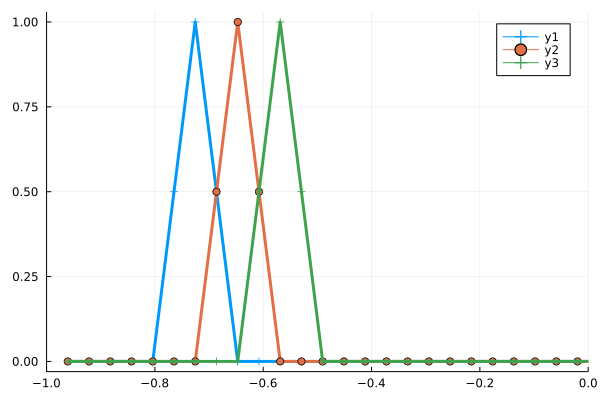

In [1]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function laplace1d(n)
    "1D Laplacion with Dirichlet boundary conditions eliminated"
    h = 2 / (n + 1)
    x = LinRange(-1, 1, n+2)[2:end-1]
    A = diagm(0 => ones(n),
        -1 => -.5*ones(n-1),
        +1 => -.5*ones(n-1))
    x, A # Hermitian(A)
end

function symbol(S, theta)
    if length(S) % 2 != 1
        error("Length of stencil must be odd")
    end
    w = length(S) ÷ 2
    phi = exp.(1im * (-w:w) * theta')
    vec(S * phi) # not! (S * phi)'
end

function plot_symbol(S, deriv=2; plot_ref=true, n_theta=30)
    theta = LinRange(-pi, pi, n_theta)
    sym = symbol(S, theta)
    rsym = real.((-1im)^deriv * sym)
    fig = plot(theta, rsym, marker=:circle, label="stencil")
    if plot_ref
        plot!(fig, th -> th^deriv, label="exact")
    end
    fig
end

function interpolate(m, stride=2)
    s1 = (stride - 1) / stride
    s2 = (stride - 2) / stride
    P = diagm(0 => ones(m),
        -1 => s1*ones(m-1), +1 => s1*ones(m-1),
        -2 => s2*ones(m-2), +2 => s2*ones(m-2))
    P[:, 1:stride:end]
end
n = 50; x, A = laplace1d(n)
P = interpolate(n, 2)
plot(x, P[:, 4:6], marker=:auto, xlims=(-1, 0))

# Galerkin approximation of $A$ in coarse space

$$ A_{2h} u_{2h} = P^T A_h P u_{2h} $$

size(A) = (50, 50)
size(A_2h) = (25, 25)


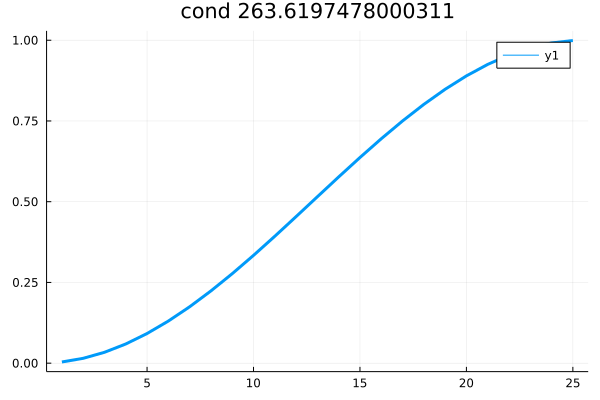

In [5]:
x, A = laplace1d(n)
P = interpolate(n)
@show size(A)
A_2h = P' * A * P
@show size(A_2h)
L_2h = eigvals(A_2h)
plot(L_2h, title="cond $(L_2h[end]/L_2h[1])")

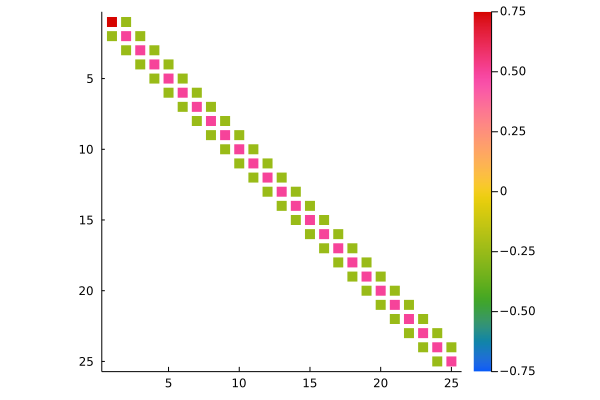

In [6]:
my_spy(A_2h)

# Coarse grid correction

Consider the $A$-orthogonal projection onto the range of $P$,
$$ S_c = P A_{2h}^{-1} P^T A $$

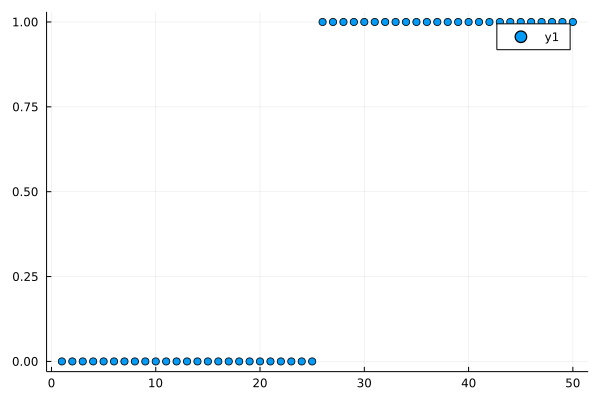

In [7]:
Sc = P * (A_2h \ P' * A)
Ls, Xs = eigen(I - Sc)
scatter(real.(Ls))

* This spectrum is typical for a projector. If $u$ is in the range of $P$, then $S_c u = u$. Why?
* For all vectors $v$ that are $A$-orthogonal to the range of $P$, we know that $S_c v = 0$. Why?

# A two-grid method

┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191
┌ Warning: No strict ticks found
└ @ PlotUtils /home/jed/.julia/packages/PlotUtils/NE7U1/src/ticks.jl:191


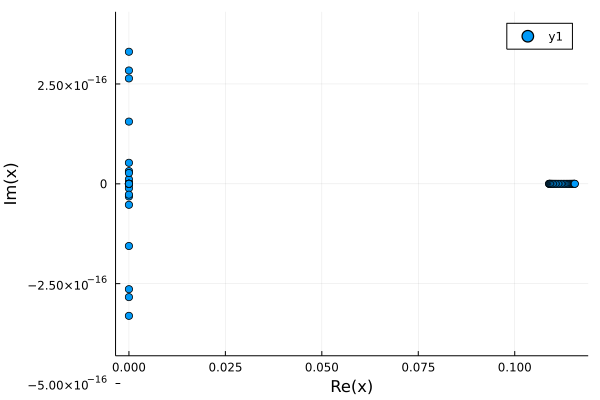

In [8]:
w = .67
T = (I - w*A) * (I - Sc) * (I - w*A)
Lt = eigvals(T)
scatter(Lt)

* Can analyze these methods in terms of frequency.
* [LFAToolkit](https://jeremylt.github.io/LFAToolkit.jl/stable/examples/diffusion/#Diffusion-operator)

# Multigrid as factorization

We can interpret factorization as a particular multigrid or domain decomposition method.

We can partition an SPD matrix as
$$A = \begin{bmatrix} F & B^T \\ B & D \end{bmatrix}$$
and define the preconditioner by the factorization
$$      M = \begin{bmatrix} I & \\ B F^{-1} & I \end{bmatrix}
      \begin{bmatrix} F &  \\ & S \end{bmatrix}
      \begin{bmatrix} I & F^{-1}B^T \\  & I \end{bmatrix}
$$
where $S = D - B F^{-1} B^T$.  $M$ has an inverse
$$
      \begin{bmatrix} I & -F^{-1}B^T \\  & I \end{bmatrix}
      \begin{bmatrix} F^{-1} &  \\ & S^{-1} \end{bmatrix}
      \begin{bmatrix} I & \\ -B F^{-1} & I \end{bmatrix} .
$$

Define the interpolation
$$ P_f = \begin{bmatrix} I \\ 0 \end{bmatrix}, \quad P_c = \begin{bmatrix} -F^{-1} B^T \\ I \end{bmatrix} $$ and rewrite as
$$ M^{-1} = [P_f\  P_c] \begin{bmatrix} F^{-1} P_f^T \\ S^{-1} P_c^T \end{bmatrix} = P_f F^{-1} P_f^T + P_c S^{-1} P_c^T.$$
The iteration matrix is thus
$$ I - M^{-1} A = I - P_f F^{-1} P_f^T J - P_c S^{-1} P_c^T A .$$

# Permute into C-F split

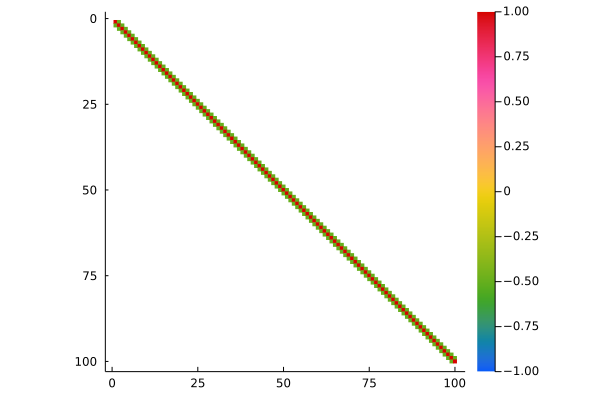

In [9]:
m = 100
x, A = laplace1d(m)
my_spy(A)

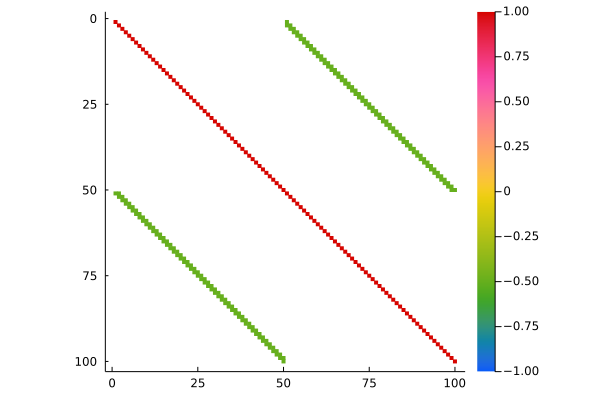

In [10]:
idx = vcat(1:2:m, 2:2:m)
J = A[idx, idx]
my_spy(J)

# Coarse basis functions

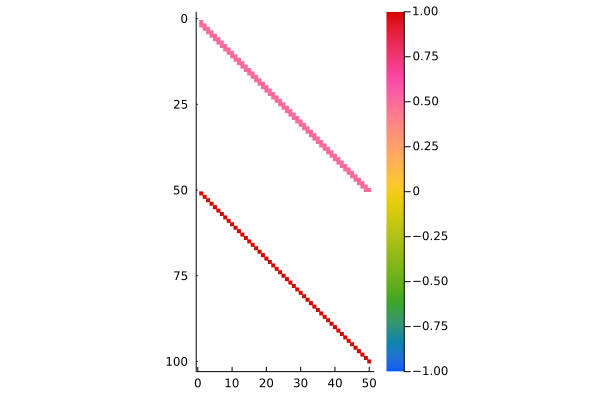

In [15]:
F = J[1:end÷2, 1:end÷2]
B = J[end÷2+1:end,1:end÷2]
P = [-F\B'; I]
my_spy(P)

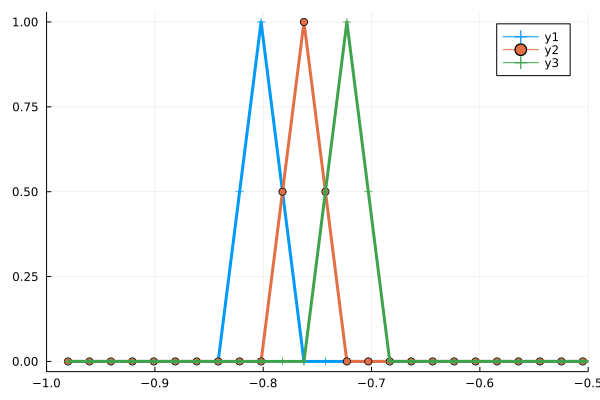

In [12]:
idxinv = zeros(Int64, m)
idxinv[idx] = 1:m
Pp = P[idxinv, :]
plot(x, Pp[:, 5:7], marker=:auto, xlims=(-1, -.5))

# From factorization to algebraic multigrid

* Factorization as a multigrid (or domain decomposition) method incurs significant cost in multiple dimensions due to lack of sparsity.
  * We can't choose enough coarse basis functions so that $F$ is diagonal, thereby making the minimal energy extension $-F^{-1} B^T$ sparse.

* Algebraic multigrid
  * Use matrix structure to aggregate or define C-points
  * Create an interpolation rule that balances sparsity with minimal energy

# Aggregation

Form aggregates from "strongly connected" dofs.

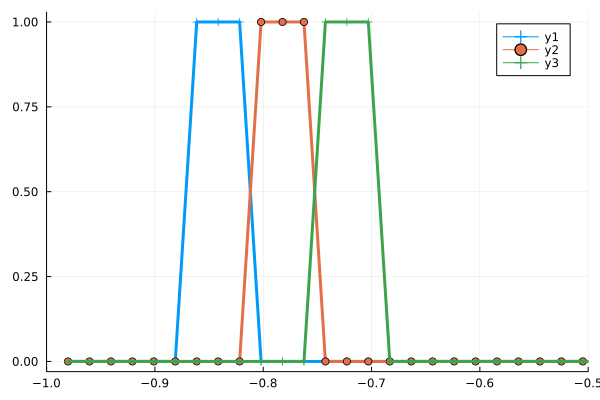

In [16]:
agg = 1 .+ (0:m-1) .÷ 3
mc = maximum(agg)
T = zeros(m, mc)
for (i, j) in enumerate(agg)
    T[i,j] = 1
end
plot(x, T[:, 3:5], marker=:auto, xlims=(-1, -.5))

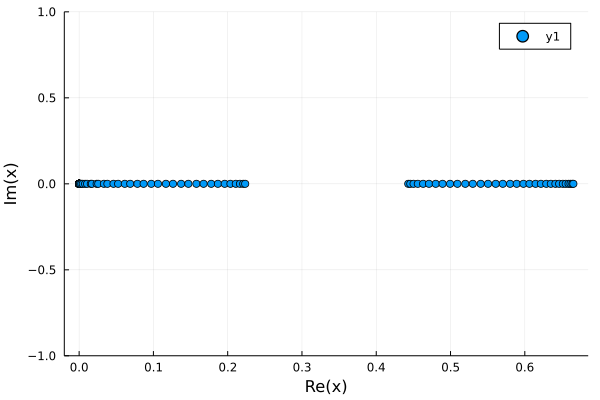

In [17]:
Sc = T * ((T' * A * T) \ T') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* simple and cheap method
* stronger smoothing (bigger `k`) doesn't help much; need more accurate coarse grid

# Smoothed aggregation

$$ P = (I - w A) T $$

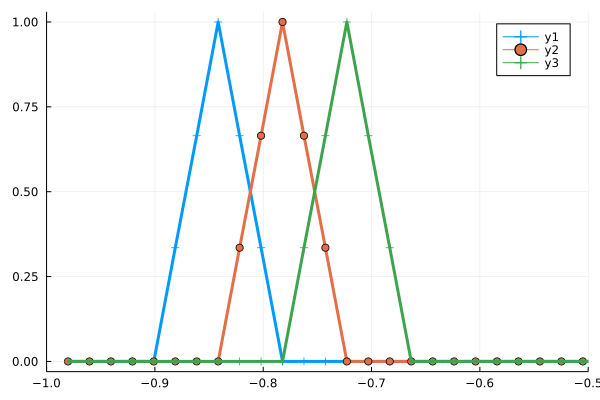

In [18]:
P = (I - w * A) * T
plot(x, P[:, 3:5], marker=:auto, xlims=(-1,-.5))

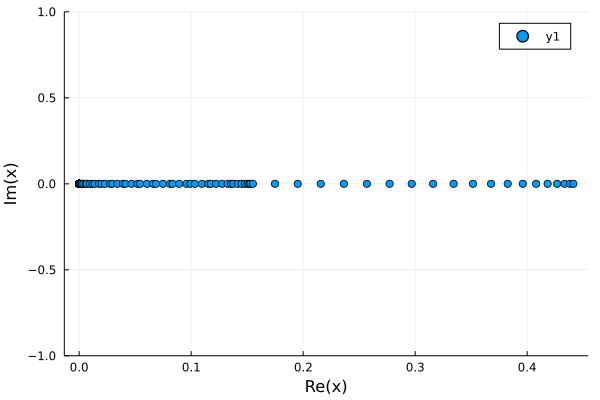

In [19]:
Sc = P * ((P' * A * P) \ P') * A
w = .67; k = 1
E = (I - w*A)^k * (I - Sc) * (I - w*A)^k
scatter(eigvals(E), ylims=(-1, 1))

* Eigenvalues are closer to zero; stronger smoothing (larger `k`) helps.
* Smoother can be made stronger using Chebyshev (like varying the damping between iterations in Jacobi)

# Multigrid in PETSc

## Geometric multigrid

* `-pc_type mg`
  * needs a grid hierarchy (automatic with `DM`)
  * `PCMGSetLevels()`
  * `PCMGSetInterpolation()`
  * `PCMGSetRestriction()`
* `-pc_mg_galerkin`
* `-pc_mg_cycle_type [v,w]`
* `-mg_levels_ksp_type chebyshev`
* `-mg_levels_pc_type jacobi`
* `-mg_coarse_pc_type svd`
  * `-mg_coarse_pc_svd_monitor` (report singular values/diagnose singular coarse grids)

## Algebraic multigrid

* `-pc_type gamg`
  * native PETSc implementation of smoothed aggregation (and experimental stuff), all `-pc_type mg` options apply.
  * [`MatSetNearNullSpace()`](https://petsc.org/release/docs/manualpages/Mat/MatSetNearNullSpace/)
  * [`MatNullSpaceCreateRigidBody()`](https://petsc.org/release/docs/manualpages/Mat/MatNullSpaceCreateRigidBody/)
  * [`DMPlexCreateRigidBody()`](https://petsc.org/release/docs/manualpages/DMPlex/DMPlexCreateRigidBody/)
  * `-pc_gamg_threshold .01` drops weak edges in strength graph
* `-pc_type ml`
  * similar to `gamg` with different defaults
* `-pc_type hypre`
  * Classical AMG (based on C-F splitting)
  * Manages its own grid hierarchy

# Searching for projects

## [GitHub codesearch](https://github.com/search)

* Check Insights -> Contributors
  * Sustained versus short-term activity
  * Number of stakeholders
  * `git shortlog -se --since=2016 | sort -n`
* Community signals
  * Code of Conduct
  * Contributing guidelines, pull request templates
  * Active review and mentoring in pull requests
* Continuous integration
  * Actions tab, also report in pull requests
  * Pipelines for repositories on GitLab

## Journals

### [Journal of Open Source Software](https://joss.theoj.org/papers)

* Papers on mature software with many users
* Immature research software with a few users, but best practices and intent to grow

### [Geoscientific Model Development](https://geoscientific-model-development.net/)

* Blends software and methods work

# Integration by parts

## One dimension

> it's the product rule backwards

\begin{align} \int_a^b d(uv) &= \int_a^b u dv + \int_a^b v du \\
(uv)_a^b &= \int_a^b u dv + \int_a^b v du \\
\int_a^b u dv &= (uv)_a^b - \int_a^b v du
\end{align}

> you can move the derivative to the other term; it'll cost you a minus sign and a boundary term

## Multiple dimensions

\begin{align}
\int_\Omega v \nabla\cdot \mathbf f = -\int_\Omega \nabla v \cdot \mathbf f + \int_{\partial \Omega} v \mathbf f \cdot \mathbf n
\end{align}

## Strong form

$$ -\nabla\cdot(\kappa \nabla u) = 0 $$

## Weak form
* multiply by a test function and integrate by parts

\begin{align} -\int_\Omega v \nabla\cdot(\kappa \nabla u) = 0, \forall v \\
\int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0
\end{align}

# Variational: from minimization to weak forms

## Minimization

Find $u\in \mathcal V$ such that

\begin{align}
u &= \arg\min \int_\Omega \frac 1 p \lVert \nabla u \rVert^p \\
&= \arg\min \int_\Omega \frac 1 p (\nabla u \cdot \nabla u)^{p/2}
\end{align}

## Variations

> If $f(x)$ is a minimum, then $df = f'(x) dx = 0$ for all $dx$.

So if $u \in \mathcal V$ is a minimizer, then 
\begin{align}
\int_\Omega \underbrace{\lVert \nabla u \rVert^{p-2}}_{\kappa(u)} \nabla u \cdot \nabla du = 0
\end{align}
for all $du \in \mathcal V$.

* It's common to use $v$ in place of $du$.
* Our discretization will reflect this structure

$$ v_h^T F(u_h) \sim \int_\Omega \nabla v \cdot \kappa(u) \cdot \nabla u $$

# Finite elements

## Problem statement

Find $u \in \mathcal V$ such that
\begin{align} \int_\Omega \nabla v \cdot \kappa \nabla u - \int_{\partial\Omega} v \underbrace{\kappa \nabla u \cdot \mathbf n}_{\text{boundary condition}} = 0, \forall v \in \mathcal V
\end{align}

### What do we need?
* A way to integrate
* A space $\mathcal V$
* Boundary conditions

## Ciarlet (1978) definition

A **finite element** is a triple $(K, P, N)$ where
* $K$ is a bounded domain with piecewise smooth boundary
* $P = \{p_j\}_1^k$ is a finite-dimensional function space over $K$ ("prime basis")
* $N = \{n_i\}_1^k$ is a basis for the dual space ("nodes")

It is common for nodes to be pointwise evaluation
$$ \langle n_i, p_j \rangle = p_j(x_i) $$

### First: choose a single element $K = \Omega$

# Quadrature

Our elements will be a line segment and we'll define quadrature on the standard line segment, $\hat K = (-1, 1)$. A quadrature is a set of points $q_i$ and weights $w_i$ such that
$$ \int_{-1}^1 f(x) \approx \sum_{i=1}^n w_i f(q_i) $$

In [20]:
default(linewidth=4)
function quad_trapezoid(n)
    q = LinRange(-1, 1, n)
    w = 2 * ones(n) / (n - 1)
    w[[1,end]] ./= 2
    q, w
end

function plot_quad_accuracy(f, F, quad)
    ns = 2 .^ (2:7)
    exact = F(1) - F(-1)
    function err(n)
        q, w = quad(n)
        w' * f.(q) - exact
    end
    errors = [abs.(err(n)) for n in ns]
    plot(ns, errors, marker=:auto, label=quad)
    plot!(ns, ns.^(-2), xscale=:log10, yscale=:log10)    
end

plot_quad_accuracy (generic function with 1 method)

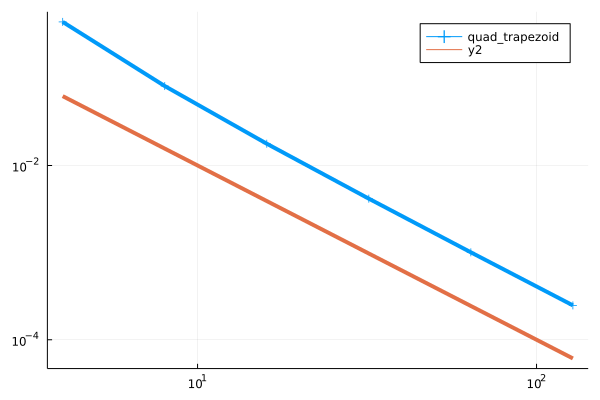

In [21]:
plot_quad_accuracy(exp, exp, quad_trapezoid)
plot_quad_accuracy(x -> 3*x^2, x -> x^3, quad_trapezoid)

# Integration via polynomial interpolation

* Pick some points $x_i$
* Evaluate the function there $f_i = f(x_i)$
* Find the polynomial that interpolates the data
* Integrate the polynomial

## What order of accuracy can we expect?
* What degree polynomials can be integrate exactly?

# Doing better: Gauss quadrature

Suppose a polynomial on the interval $[-1,1]$ can be written as

$$ P_n(x) q(x) + r(x) $$

where $P_n(x)$ is the $n$th Legendre polnomials and both $q(x)$ and $r(x)$ are polynomials of maximum degree $n-1$.

* Why is $\int_{-1}^1 P_n(x) q(x) = 0$?
* Can every polynomials of degree $2n-1$ be written in the above form?
* How many roots does $P_n(x)$ have on the interval?
* Can we choose points $\{x_i\}$ such that the first term is 0?

If $P_n(x_i) = 0$ for each $x_i$, then we need only integrate $r(x)$, which is done exactly by integrating its interpolating polynomial.  How do we find these roots $x_i$?

# Gauss-Legendre in code

1. Solve for the points, compute the weights
  * Use a Newton solver to find the roots. You can use the recurrence to write a recurrence for the derivatives.
  * Create a Vandermonde matrix and extract the first row of the inverse or (using more structure) the derivatives at the quadrature points.
2. Use duality of polynomial roots and matrix eigenvalues.
  * A fascinating mathematical voyage (topic of graduate linear algebra class).

In [22]:
function gauss_legendre(n)
    """Gauss-Legendre integration using Golub-Welsch algorithm"""
    beta = @. .5 / sqrt(1 - (2 * (1:n-1))^(-2))
    T = diagm(-1 => beta, 1 => beta)
    D, V = eigen(T)
    w = V[1,:].^2 * 2
    q = D
    q, w
end

gauss_legendre (generic function with 1 method)

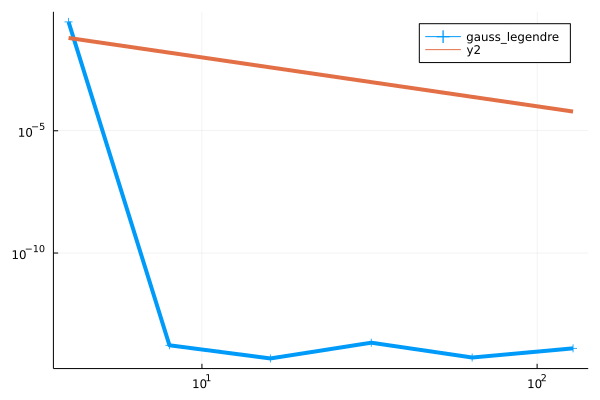

In [23]:
plot_quad_accuracy(exp, exp, gauss_legendre)
plot_quad_accuracy(x -> 11*x^10, x -> x^11, gauss_legendre)

# Legendre polynomials

In [24]:
function vander_legendre(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    Q[:, 2] = x
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
    end
    Q
end

vander_legendre (generic function with 2 methods)

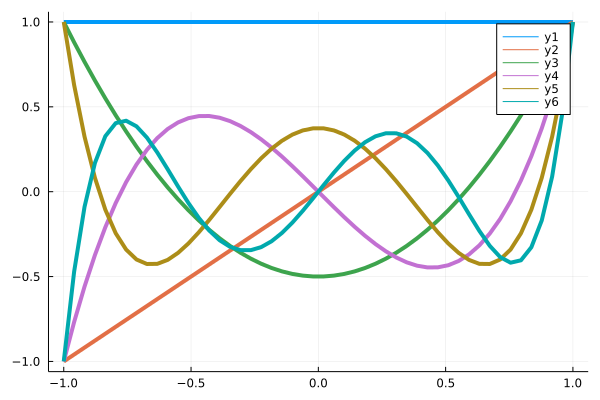

In [25]:
x = LinRange(-1, 1, 50)
P = vander_legendre(x, 6)
plot(x, P)

# Prime to nodal basis

A **nodal basis** $\{ \phi_j(x) \}$ is one that satisfies
$ n_i(\phi_j) = \delta_{ij} . $

We write $\phi_j$ in the prime basis by solving with the generalized Vandermonde matrix $V_{ij} = \langle n_i, p_j \rangle$,
$$ \phi_j(x) = \sum_k p_k(x) (V^{-1})_{k,j} . $$

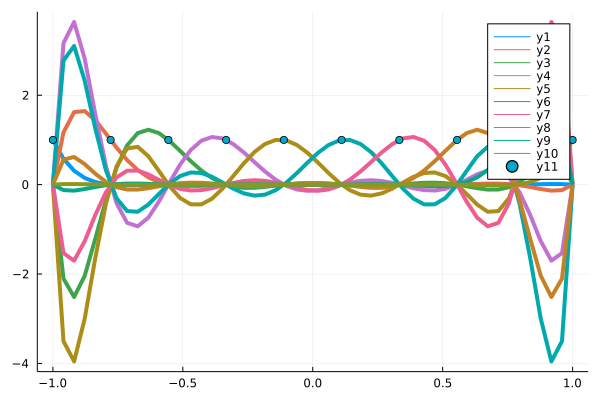

In [26]:
k = 10
xn = LinRange(-1, 1, k)
V = vander_legendre(xn)
xx = LinRange(-1, 1, 50)
Pxx = vander_legendre(xx, k)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

┌ Info: Precompiling FastGaussQuadrature [442a2c76-b920-505d-bb47-c5924d526838]
└ @ Base loading.jl:1664


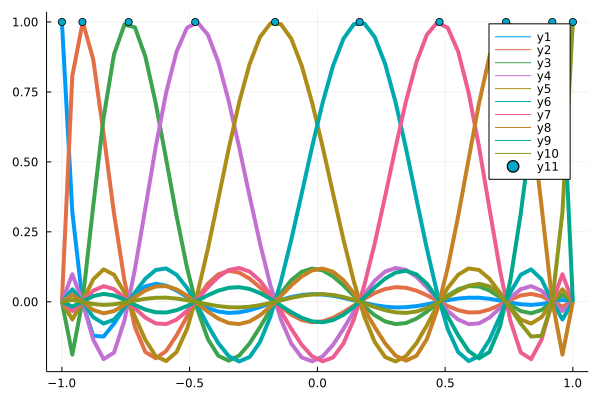

In [27]:
using FastGaussQuadrature
xn, _ = gausslobatto(k)
V = vander_legendre(xn)
Pn = Pxx / V
plot(xx, Pn)
scatter!(xn, one.(xn))

In [36]:
function vander_legendre_deriv(x, k=nothing)
    if isnothing(k)
        k = length(x) # Square by default
    end
    m = length(x)
    Q = ones(m, k)
    dQ = zeros(m, k)
    Q[:, 2] = x
    dQ[:, 2] .= 1
    for n in 1:k-2
        Q[:, n+2] = ((2*n + 1) * x .* Q[:, n+1] - n * Q[:, n]) / (n + 1)
        dQ[:, n+2] = (2*n + 1) * Q[:,n+1] + dQ[:,n]
    end
    Q, dQ
end

vander_legendre_deriv (generic function with 2 methods)

# Galerkin method: $L^2$ projection

A nice test problem that doesn't require derivatives or boundary conditions:
Find $u \in \mathcal V_h$ such that
$$ \int_{-1}^1 v(x) \big[ u(x) - f(x) \big] = 0, \quad \forall v \in \mathcal V_h$$

In [37]:
function febasis(P, Q)
    x, _ = gausslobatto(P)
    q, w = gausslegendre(Q)
    Pk, _ = vander_legendre_deriv(x)
    Bp, Dp = vander_legendre_deriv(q, P)
    B = Bp / Pk
    D = Dp / Pk
    x, q, w, B, D
end

function L2_galerkin(P, Q, f)
    x, q, w, B, _ = febasis(P, Q)
    A = B' * diagm(w) * B
    rhs = B' * diagm(w) * f.(q)
    u = A \ rhs
    x, u
end

L2_galerkin (generic function with 1 method)

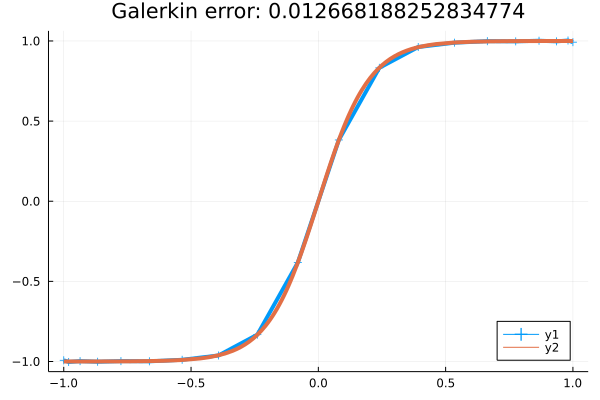

In [38]:
f(x) = tanh(5*x)
x, u = L2_galerkin(20, 20, f)
error = u - f.(x)
plot(x, u, marker=:auto, legend=:bottomright)
plot!(f, title="Galerkin error: $(norm(error))")

# Convergence of the Galerkin method

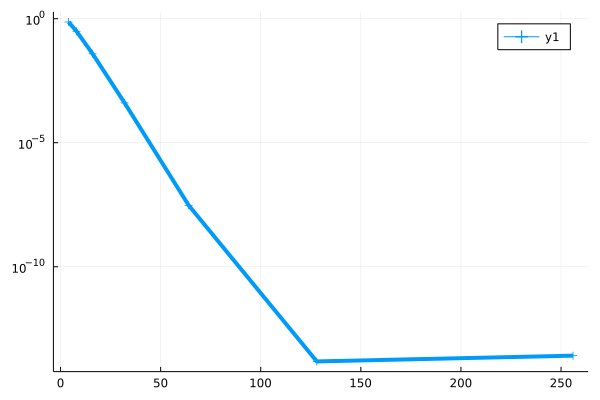

In [39]:
ns = 2 .^ (2:8)
function L2_error(n)
    x, u = L2_galerkin(n, n, f)
    norm(u - f.(x))
end
plot(ns, L2_error.(ns), marker=:auto, yscale=:log10)

# Galerkin error estimates

We introduce the notation
$$ a(v, u) = \int_\Omega \nabla v(x) \cdot \nabla u(x) $$
and note that $a$ is
* bilinear (linear in each of its arguments)
* symmetric: $a(u, v) = a(v,u)$
* positive definite: $a(u, u) > 0$ when $u \ne 0$
thus defines an inner product on the function space $V$.

We also introduce the $L^2$ inner product
$$ \langle u, v \rangle = \int_\Omega u(x) v(x) $$
so that our continuous weak form is to find $u \in V$ such that
$$ a(v, u) = \langle v, f \rangle, \quad \forall v\in V. $$
Our Galerkin discretization is to find $u_h \in V_h \subset V$ such that
$$ a(v_h, u_h) = \langle v_h, f \rangle, \quad \forall v_h \in V_h . $$
Since $V_h \subset V$, we can subtract these two, yielding
$$ a(v_h, u_h - u) = 0, \quad \forall v_h \in V_h .$$
This says that the error in the discrete solution $u_h - u$ is $a$-orthogonal to all test functions $v_h$.

# Galerkin optimality via energy norms

We can also define the "energy norm" or $a$-norm,
$$ \lVert u \rVert_a = \sqrt{a(u,u)} . $$
This norm satisfies the Cauchy-Schwarz inequality,
$$ \lvert a(u,v) \rvert \le \lVert u \rVert_a \lVert v \rVert_a . $$
Now,
\begin{align}
\lVert u_h - u \rVert_a^2 &= a(u_h - u, u_h - u) \\
&= a(u_h - v_h, u_h - u) + a(v_h - u, u_h - u) \\
&= a(v_h - u, u_h - u) \\
&\le \lVert v_h - u \rVert_a \lVert u_h - u \rVert_a .
\end{align}
In other words,
$$\lVert u_h - u \rVert_a \le \lVert v_h - u \rVert_a, \quad \forall v_h \in V_h .$$
So the solution $u_h$ computed by the Galerkin discretization is optimal over the subspace $V_h$ as measured in the $a$-norm.

## Observations
* The Galerkin method computes the exact solution any time it resides in the subspace $V_h$.
* The Galerkin method is automatically symmetric any time the weak form is symmetric.
* The Galerkin method can be spectrally accurate, similar to the Chebyshev finite difference methods.
* For a nonlinear problem, discretization and differentiation will commute.

# Galerkin method for Poisson

$$ \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u = \int_{\Omega} v f, \forall v$$

In [40]:
function poisson_galerkin(P, Q, kappa, f)
    x, q, w, B, D = febasis(P, Q)
    A = D' * diagm(w .* kappa.(q)) * D
    rhs = B' * diagm(w) * f.(q)
    # Boundary conditions
    rhs[[1]] .= 0
    A[1, :] .= 0
    A[1, 1] = 1
    #A[end, :] .= 0
    #A[end, end] = 1
    u = A \ rhs
    x, u
end

poisson_galerkin (generic function with 1 method)

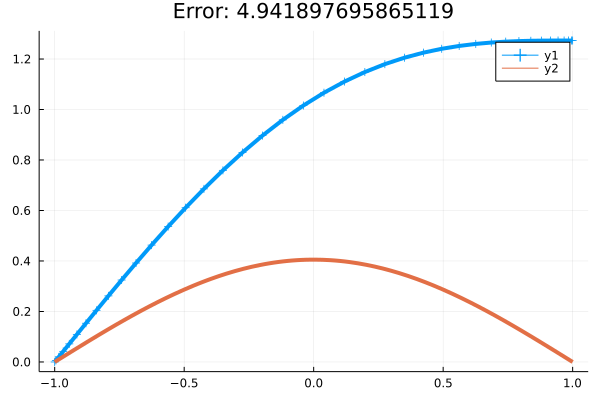

In [43]:
kappa(x) = 1# 0.6 .+ 0.4 * sin.(pi*x)
x, u = poisson_galerkin(40, 40, one, x -> cos(x*pi/2))
plot(x, u, marker=:auto)
uexact(x) = cos(x*pi/2) * (2/pi)^2
plot!(uexact, title="Error: $(norm(u - uexact.(x)))")

## What if we only impose the boundary condition on one side?

# Galerkin preserves symmetry

The bilinear operator is symmetric if $a(v,u) = a(u,v)$,

$$ a(v,u) = \int_{\Omega} \nabla v \cdot \kappa \cdot \nabla u $$

This is symmetric even for
* variable coefficients
* any Neumann-type boundary conditions
* Dirichlet if eliminated or lifted symmetrically
* arbitrary grid spacing (and mesh topology in multiple dimensions)

In [123]:
x, q, w, B, D = febasis(7, 10)
A = D' * diagm(w .* kappa.(q)) * D
@show norm(A - A')
eigvals(A)

norm(A - A') = 7.765675694969792e-16


7-element Vector{Float64}:
  1.1350210845831068e-15
  0.21130426481190864
  1.3866142540744655
  3.2701200000673087
  6.853818219483833
 10.692355373099744
 14.545787888462765

## What if we use too few quadrature points?

![](../img/libCEED-2-trim.svg)

# General form
$$ \int_\Omega v\cdot f_0(u, \nabla u) + \nabla v\cdot f_1(u, \nabla u) = 0, \quad \forall v$$
we discretize as
$$ \sum_e \mathcal E_e^T \Big( B^T W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_0(\tilde u, \nabla \tilde u) + D^T \left(\frac{\partial X}{\partial x}\right)^{T} W \left\lvert \frac{\partial x}{\partial X} \right\rvert f_1(\tilde u, \nabla\tilde u) \Big) = 0 $$
where $\tilde u = B \mathcal E_e u$ and $\nabla \tilde u = \frac{\partial X}{\partial x} D \mathcal E_e u$ are the values and gradients evaluated at quadrature points.

## Isoparametric mapping

Given the reference coordinates $X \in \hat K \subset R^n$ and physical coordinates $x(X)$, an integral on the physical element can be written
$$ \int_{K = x(\hat K)} f(x) dx = \int_K \underbrace{\left\lvert \frac{\partial x}{\partial X} \right\rvert}_{\text{determinant}} f(x(X)) dX .$$

| Notation | Meaning |
|---------|:-------------|
| $x$ | physical coordinates |
| $X$ | reference coordinates |
| $\mathcal E_e$ | restriction from global vector to element $e$ |
| $B$ | values of nodal basis functions at quadrature ponits on reference element |
| $D$ | gradients of nodal basis functions at quadrature points on reference element|
| $W$ | diagonal matrix of quadrature weights on reference element |
| $\frac{\partial x}{\partial X} = D \mathcal E_e x $ | gradient of physical coordinates with respect to reference coordinates |
| $\left\lvert \frac{\partial x}{\partial X}\right\rvert$ | determinant of coordinate transformation at each quadrature point |
| $\frac{\partial X}{\partial x} = \left(\frac{\partial x}{\partial X}\right)^{-1}$ | derivative of reference coordinates with respect to physical coordinates |

# Finite element mesh and restriction

In [64]:
function fe1_mesh(P, nelem)
    x = LinRange(-1, 1, nelem+1)
    rows = Int[]
    cols = Int[]
    for i in 1:nelem
        append!(rows, (i-1)*P+1:i*P)
        append!(cols, (i-1)*(P-1)+1:i*(P-1)+1)
    end
    x, sparse(rows, cols, ones(nelem*P))
end
P, nelem = 4, 3
x, E = fe1_mesh(P, nelem)

(range(-1.0, stop=1.0, length=4), 
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   1.0)

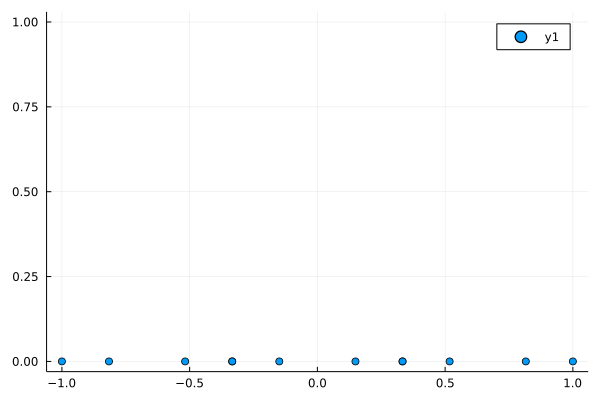

In [72]:
function xnodal(x, P)
    xn = Float64[]
    xref, _ = gausslobatto(P)
    for i in 1:nelem
        xL, xR = x[i:i+1]
        append!(xn, (xL+xR)/2 .+ (xR-xL)/2 * xref)
    end
    xn
end
xn = xnodal(x, 4)
scatter(xn, zero, marker=:auto)

# Finite element assembly

In [ ]:
function fe_assemble(P, Q, nelem)
    x, E = fe1_mesh(P, nelem)
    